# Now lets make a base line with TF-IDF and Some Regression model

In [52]:
from paths import DATA_PATH
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslansirazhetdinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv')
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2023-05-06,Инвесторы все сильнее верят в дефолт США через...,Джо Байден не хочет повышать потолок госдолга,https://www.finam.ru/publications/item/investo...,Митрофанов Никита,negative,235.83,240.93,233.42,237.06,11352.0
1,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0
2,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
3,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
4,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
30610,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
30611,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
30612,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0


# Соединяем заголовок с самой новостью, лемматизируем слова

In [3]:
title_texts = df.title.fillna('') + df.text.fillna('')

In [4]:
def normalize_text(df):
    re_word = re.compile(r'\b[^\d\W]+\b')
    texts = df.str.lower()
    mystem = Mystem()
    texts.dropna(inplace=True)
    texts = texts.apply(lambda line: ' '.join(re.findall(re_word, line)))
    texts = texts.apply(lambda line: ' '.join(filter(lambda x: x not in russian_stopwords, mystem.lemmatize(line))))

    return texts

normalized_news = normalize_text(title_texts)

In [5]:
normalized_news

0        инвестор     сильно   верить     дефолт   сша ...
1        встреча     зерновой   сделка     уровень   за...
2        закрытие   дивидендный   реестр     сбербанк  ...
3        банк   сша   депозит   сокращаться   кредит   ...
4        результат   ford     итог   прошедший   год   ...
                               ...                        
30609    реальный   доход   россиянин     год   мочь   ...
30610    постпред   ес     воскресение     достигать   ...
30611    сбербанк   увеличивать   сумма   кредит     ип...
30612    юань   хороший   инструмент     хеджирование  ...
30613    заявка     транзит   российский   газ     укра...
Length: 30614, dtype: object

In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(normalized_news)
X

<30614x16507 sparse matrix of type '<class 'numpy.float64'>'
	with 493169 stored elements in Compressed Sparse Row format>

In [7]:
y = df.close

# Работаем с временным рядом - поэтому делим без перемешивания

In [8]:
test_size = 0.22
n_samples = X.shape[0]


X_train = X[:n_samples - int(n_samples * test_size)]
y_train = y[:n_samples - int(n_samples * test_size)]
X_test = X[-int(n_samples * test_size):]
y_test = y[-int(n_samples * test_size):]

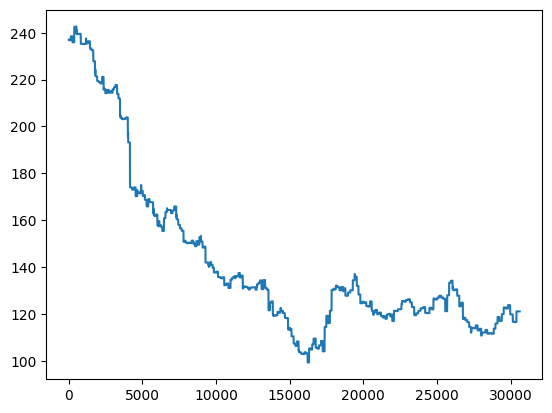

In [9]:
plt.plot(y)

In [33]:
def test_model(reg, moving_average=None):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print('MSE', mean_squared_error(y_test, y_pred))
    y_pred = reg.predict(X)
    if moving_average:
        y_pred = np.convolve(y_pred, np.ones(moving_average_n)/moving_average_n, mode='valid')
    fig, ax = plt.subplots(1,1)
    ax.plot(y_pred, label='pred')
    ax.plot(y, label='true')
    ax.legend()
    return reg

MSE 904.3946977791553


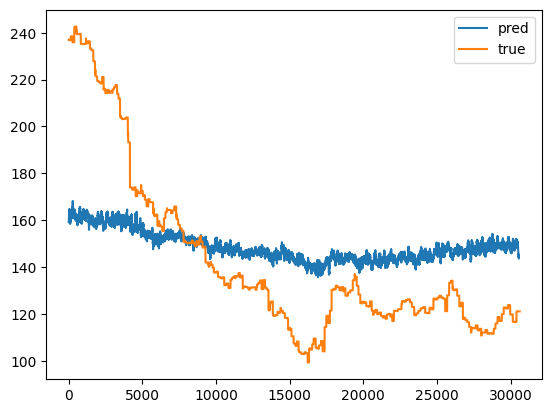

In [25]:
model = test_model(linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv=2), moving_average=50)

In [28]:
model.alpha_

10.0

MSE 863.2935687810301


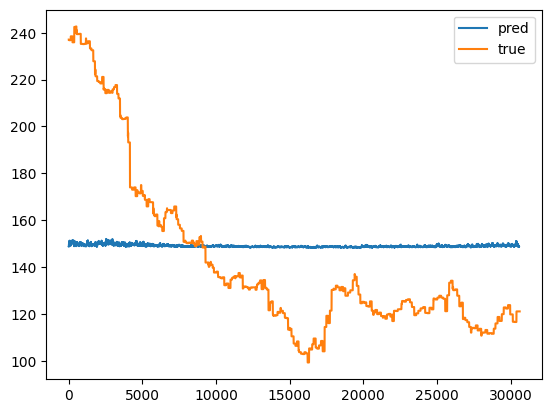

In [24]:
model = test_model(linear_model.Lasso(alpha=0.1), moving_average=50)

MSE 894.8389842200884


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [10, 100, 1000, None],
                         'max_features': [10, 100, 500, None],
                         'min_samples_leaf': [1, 2, 3, 10, 20]})

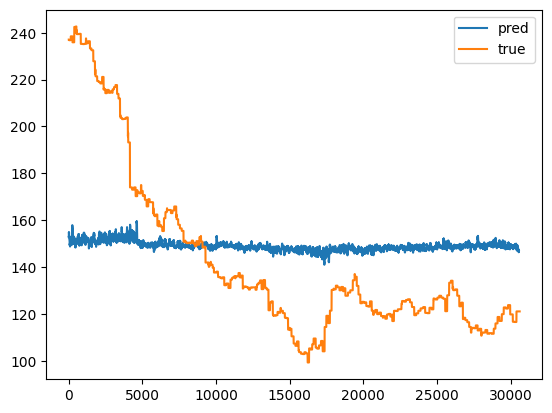

In [55]:
param_grid = {
    'max_depth': [10, 100, 1000, None],
    'max_features': [10, 100, 500, None],
    'min_samples_leaf': [1, 2, 3, 10, 20],
}

model = test_model(
    GridSearchCV(
        estimator=tree.DecisionTreeRegressor(
            random_state=42,
        ),
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=2),
    ),
    moving_average=50,
)

MSE 894.8389842200884


DecisionTreeRegressor(max_depth=10, max_features=500, min_samples_leaf=20,
                      random_state=42)

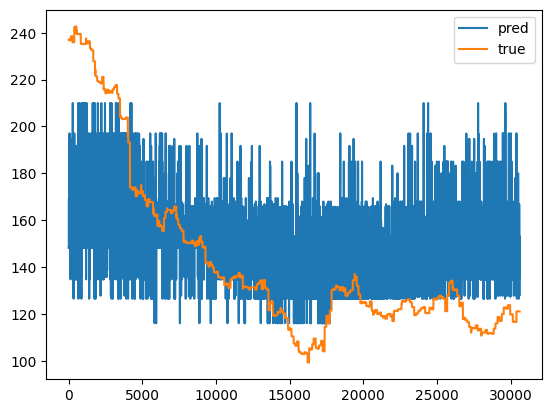

In [73]:
test_model(
    tree.DecisionTreeRegressor(
        **model.best_params_,
        random_state=42,
    ),
    moving_average=None,
)

## Lest set a baseline MSE = 863.3